**Car Model Detection using PyTorch**


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/Shareddrives")
!ls

In [4]:
%matplotlib inline
import time
import tarfile
import os
import csv
import PIL.Image
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

In [5]:
import torch
import json
from random import randint
from pathlib import Path
from PIL import Image
from scipy.io import loadmat
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from matplotlib.ticker import FormatStrFormatter
from google.colab.patches import cv2_imshow
from matplotlib.pyplot import imshow
from IPython.display import Image

**Download data files** [Cars Dataset](http://ai.stanford.edu/~jkrause/cars/car_dataset.html)


In [6]:
#Download full training data thanks to 'James Wang' for the idea.
!wget -O /tmp/cars_train.tgz  http://imagenet.stanford.edu/internal/car196/cars_train.tgz \

--2022-05-18 16:23:35--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://image-net.org/internal/car196/cars_train.tgz [following]
--2022-05-18 16:23:36--  https://image-net.org/internal/car196/cars_train.tgz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-05-18 16:23:36 ERROR 404: Not Found.



In [7]:
# read the .tgz file and extract training data.
trainTar = tarfile.open('/content/drive/MyDrive/Task 2/cars_train.tgz')
# Folder to extract to
trainTar.extractall('/tmp/train') 
trainTar.close()

In [8]:
#Download full testing data
!wget -O /tmp/cars_test.tgz http://imagenet.stanford.edu/internal/car196/cars_test.tgz \

--2022-05-18 16:23:48--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://image-net.org/internal/car196/cars_test.tgz [following]
--2022-05-18 16:23:48--  https://image-net.org/internal/car196/cars_test.tgz
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-05-18 16:23:48 ERROR 404: Not Found.



In [9]:
# read the .tgz file and extract testing data to tmp/test/
testTar = tarfile.open('/content/drive/MyDrive/Task 2/cars_test.tgz')
testTar.extractall('/tmp/test')
testTar.close()

In [10]:
#Download labels
!wget -O /tmp/car_devkit.tgz http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz \
    
Path("/tmp/annos").mkdir(parents=True, exist_ok=True)
!wget -O /tmp/annos/anno_test.csv https://people.ucsc.edu/~jwang402/carslabel/anno_test.csv \

--2022-05-18 16:24:02--  http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 403 Forbidden
2022-05-18 16:24:03 ERROR 403: Forbidden.

--2022-05-18 16:24:03--  https://people.ucsc.edu/~jwang402/carslabel/anno_test.csv
Resolving people.ucsc.edu (people.ucsc.edu)... 128.114.119.88
Connecting to people.ucsc.edu (people.ucsc.edu)|128.114.119.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225299 (220K) [text/csv]
Saving to: ‘/tmp/annos/anno_test.csv’

/tmp/annos/anno_tes 100%[===================>] 220.02K  1013KB/s    in 0.2s    

2022-05-18 16:24:03 (1013 KB/s) - ‘/tmp/annos/anno_test.csv’ saved [225299/225299]



In [11]:
#extract labels to /tmp/labels/
labelTar = tarfile.open('/content/drive/MyDrive/Task 2/car_devkit.tgz')
labelTar.extractall('/tmp/labels')
labelTar.close()

**Class Mapping loding**
There are 196 class

In [12]:
#see what inside the .mat file
meta = loadmat('/tmp/labels/devkit/cars_meta.mat')
meta.keys()

dict_keys(['__header__', '__version__', '__globals__', 'class_names'])

In [13]:
#see the type and shap
type(meta['class_names']),meta['class_names'].shape

(numpy.ndarray, (1, 196))

In [14]:
#class_names elements
[item.flat[0] for item in meta['class_names'][0][0]]
classes = [[row.flat[0] for row in line] for line in meta['class_names'][0]]
classes

[['AM General Hummer SUV 2000'],
 ['Acura RL Sedan 2012'],
 ['Acura TL Sedan 2012'],
 ['Acura TL Type-S 2008'],
 ['Acura TSX Sedan 2012'],
 ['Acura Integra Type R 2001'],
 ['Acura ZDX Hatchback 2012'],
 ['Aston Martin V8 Vantage Convertible 2012'],
 ['Aston Martin V8 Vantage Coupe 2012'],
 ['Aston Martin Virage Convertible 2012'],
 ['Aston Martin Virage Coupe 2012'],
 ['Audi RS 4 Convertible 2008'],
 ['Audi A5 Coupe 2012'],
 ['Audi TTS Coupe 2012'],
 ['Audi R8 Coupe 2012'],
 ['Audi V8 Sedan 1994'],
 ['Audi 100 Sedan 1994'],
 ['Audi 100 Wagon 1994'],
 ['Audi TT Hatchback 2011'],
 ['Audi S6 Sedan 2011'],
 ['Audi S5 Convertible 2012'],
 ['Audi S5 Coupe 2012'],
 ['Audi S4 Sedan 2012'],
 ['Audi S4 Sedan 2007'],
 ['Audi TT RS Coupe 2012'],
 ['BMW ActiveHybrid 5 Sedan 2012'],
 ['BMW 1 Series Convertible 2012'],
 ['BMW 1 Series Coupe 2012'],
 ['BMW 3 Series Sedan 2012'],
 ['BMW 3 Series Wagon 2012'],
 ['BMW 6 Series Convertible 2007'],
 ['BMW X5 SUV 2007'],
 ['BMW X6 SUV 2012'],
 ['BMW M3 Coup

In [15]:
# creating a class dictionary
Dictionary = {}
Count = 1
for i in classes:
    Dictionary.update({Count:i[0]})
    Count = Count + 1
term = 0
for j, model in Dictionary.items():
    print('Class no', j,'Model: ', model)
    term = term + 1
    if term == 4:
        break
print('...')


Class no 1 Model:  AM General Hummer SUV 2000
Class no 2 Model:  Acura RL Sedan 2012
Class no 3 Model:  Acura TL Sedan 2012
Class no 4 Model:  Acura TL Type-S 2008
...


**Load and labels for training**

In [16]:
# see what inside cars_train_annos
labelfile = loadmat('/tmp/labels/devkit/cars_train_annos.mat')
labelfile.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

In [17]:
# type and shap of label file
type(labelfile['annotations']),labelfile['annotations'].shape

(numpy.ndarray, (1, 8144))

In [18]:
# creating training and label. Here i is item
labelfile['annotations'][0][0]['bbox_x1'], labelfile['annotations'][0][0]['fname']
[i.flat[0] for i in labelfile['annotations'][0][0]]

[39, 116, 569, 375, 14, '00001.jpg']

In [19]:
trainLabels = [[row.flat[0] for row in line] for line in labelfile['annotations'][0]]
trainLabels

[[39, 116, 569, 375, 14, '00001.jpg'],
 [36, 116, 868, 587, 3, '00002.jpg'],
 [85, 109, 601, 381, 91, '00003.jpg'],
 [621, 393, 1484, 1096, 134, '00004.jpg'],
 [14, 36, 133, 99, 106, '00005.jpg'],
 [259, 289, 515, 416, 123, '00006.jpg'],
 [88, 80, 541, 397, 89, '00007.jpg'],
 [73, 79, 591, 410, 96, '00008.jpg'],
 [20, 126, 1269, 771, 167, '00009.jpg'],
 [21, 110, 623, 367, 58, '00010.jpg'],
 [51, 93, 601, 393, 49, '00011.jpg'],
 [6, 62, 499, 286, 186, '00012.jpg'],
 [30, 36, 418, 307, 135, '00013.jpg'],
 [31, 246, 778, 540, 85, '00014.jpg'],
 [32, 77, 589, 379, 193, '00015.jpg'],
 [27, 49, 611, 396, 172, '00016.jpg'],
 [39, 52, 233, 150, 14, '00017.jpg'],
 [3, 8, 190, 147, 73, '00018.jpg'],
 [247, 287, 1366, 761, 192, '00019.jpg'],
 [17, 281, 961, 596, 57, '00020.jpg'],
 [17, 156, 695, 375, 79, '00021.jpg'],
 [212, 538, 1893, 1131, 36, '00022.jpg'],
 [11, 28, 476, 234, 120, '00023.jpg'],
 [53, 126, 973, 621, 170, '00024.jpg'],
 [34, 87, 567, 343, 194, '00025.jpg'],
 [30, 174, 598, 379,

In [20]:
#creat datafram from the above and name columns
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname'] #df is view 
df = pd.DataFrame(trainLabels, columns=columns)
df.head()


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,-122,00004.jpg
4,14,36,133,99,106,00005.jpg


In [21]:
#label file for car test
lf = loadmat('/tmp/labels/devkit/cars_test_annos.mat')
lf.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

In [22]:
type(lf['annotations']),lf['annotations'].shape

(numpy.ndarray, (1, 8041))

In [23]:
# creating testing and label. Here i is item
type(lf['annotations'][0][0]),lf['annotations'][0][0].shape
lf['annotations'][0][0]['bbox_x1'], lf['annotations'][0][0]['fname']
[i.flat[0] for i in lf['annotations'][0][0]]

[30, 52, 246, 147, '00001.jpg']

In [24]:
testLabels = [[row.flat[0] for row in line] for line in lf['annotations'][0]]
testLabels

[[30, 52, 246, 147, '00001.jpg'],
 [100, 19, 576, 203, '00002.jpg'],
 [51, 105, 968, 659, '00003.jpg'],
 [67, 84, 581, 407, '00004.jpg'],
 [140, 151, 593, 339, '00005.jpg'],
 [20, 77, 420, 301, '00006.jpg'],
 [249, 166, 2324, 1459, '00007.jpg'],
 [119, 215, 1153, 719, '00008.jpg'],
 [1, 7, 275, 183, '00009.jpg'],
 [28, 55, 241, 177, '00010.jpg'],
 [30, 20, 438, 253, '00011.jpg'],
 [14, 21, 242, 156, '00012.jpg'],
 [1, 42, 495, 313, '00013.jpg'],
 [8, 63, 395, 287, '00014.jpg'],
 [50, 103, 569, 403, '00015.jpg'],
 [80, 116, 359, 250, '00016.jpg'],
 [9, 48, 630, 361, '00017.jpg'],
 [113, 66, 554, 369, '00018.jpg'],
 [82, 70, 277, 168, '00019.jpg'],
 [25, 56, 569, 416, '00020.jpg'],
 [11, 55, 298, 196, '00021.jpg'],
 [11, 65, 484, 304, '00022.jpg'],
 [37, 115, 1561, 1096, '00023.jpg'],
 [1, 26, 160, 89, '00024.jpg'],
 [131, 301, 1279, 876, '00025.jpg'],
 [93, 20, 523, 371, '00026.jpg'],
 [59, 101, 938, 652, '00027.jpg'],
 [15, 93, 608, 408, '00028.jpg'],
 [43, 67, 386, 340, '00029.jpg'],


In [25]:
# read annotation csv file
csv_file = open('/tmp/annos/anno_test.csv') 
read = csv.reader(csv_file, delimiter=',')
testDictionary = {}
CountClass = 1

In [26]:
for row in read:
        testDictionary.update({row[0]:row[5]})
        classCount = CountClass + 1
len(testDictionary)

8041

**Train Labels**

In [27]:
for i in range(len(trainLabels) - 10, len(trainLabels)):
    print(trainLabels[i])

[53, 44, 430, 293, 85, '08135.jpg']
[54, 122, 942, 590, 187, '08136.jpg']
[30, 287, 999, 658, 17, '08137.jpg']
[50, 155, 637, 392, 181, '08138.jpg']
[117, 84, 583, 403, 188, '08139.jpg']
[3, 44, 423, 336, 78, '08140.jpg']
[138, 150, 706, 523, 196, '08141.jpg']
[26, 246, 660, 449, 163, '08142.jpg']
[78, 526, 1489, 908, 112, '08143.jpg']
[20, 240, 862, 677, 17, '08144.jpg']


**Test Labels**

In [28]:
for i in range(len(testLabels) - 10, len(testLabels)):
    print(testLabels[i])

[69, 109, 662, 450, '08032.jpg']
[216, 110, 903, 590, '08033.jpg']
[16, 139, 590, 350, '08034.jpg']
[10, 18, 89, 61, '08035.jpg']
[3, 81, 778, 561, '08036.jpg']
[49, 57, 1169, 669, '08037.jpg']
[23, 18, 640, 459, '08038.jpg']
[33, 27, 602, 252, '08039.jpg']
[33, 142, 521, 376, '08040.jpg']
[77, 73, 506, 380, '08041.jpg']


**Training Images**

Obtain all training photos and crops them according to the bounding box, then saves them to a new directory. The training picture directory comprises subdirectories labelled by class name, with each relevant image in its own folder. 8% of photos are saved for validation.

In [29]:
print('we will be processing',len(trainLabels), "images.")
Path("/tmp/processedTrain").mkdir(parents=True, exist_ok=True)
Path("/tmp/processedValidation").mkdir(parents=True, exist_ok=True)

we will be processing 8144 images.


In [30]:
#trainLabels
# i[0] i[1] i[2] i[3] i[4]     i[4]     i[5]
#[39, 116, 569, 375, 14, '00001.jpg' , '  ']
count = 1
for i in trainLabels:
    print('Processing image', count, 'of', len(trainLabels))
    #bbox
    x1 = i[0]
    y1 = i[1]
    x2 = i[2]
    y2 = i[3]
    class_num = i[4]
    filename = i[5]
    address = "/tmp/train/cars_train/" + filename
    classAppend = Dictionary.get(class_num) + '/'
    if count < 8000:
        saveDir = "/tmp/processedTrain/" + classAppend
    else:
        saveDir = "/tmp/processedValidation/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    region.save(saveAddress)    
    print('Saved image', saveAddress)
    count = count + 1
print(" ")
print("Done.")

Streaming output truncated to the last 5000 lines.
Processing image 5646 of 8144
Saved image /tmp/processedTrain/Chevrolet HHR SS 2010/05646.jpg
Processing image 5647 of 8144
Saved image /tmp/processedTrain/Audi TT RS Coupe 2012/05647.jpg
Processing image 5648 of 8144
Saved image /tmp/processedTrain/Bentley Arnage Sedan 2009/05648.jpg
Processing image 5649 of 8144
Saved image /tmp/processedTrain/Ford F-150 Regular Cab 2007/05649.jpg
Processing image 5650 of 8144
Saved image /tmp/processedTrain/BMW 3 Series Sedan 2012/05650.jpg
Processing image 5651 of 8144
Saved image /tmp/processedTrain/Fisker Karma Sedan 2012/05651.jpg
Processing image 5652 of 8144
Saved image /tmp/processedTrain/MINI Cooper Roadster Convertible 2012/05652.jpg
Processing image 5653 of 8144
Saved image /tmp/processedTrain/Dodge Dakota Crew Cab 2010/05653.jpg
Processing image 5654 of 8144
Saved image /tmp/processedTrain/BMW 1 Series Coupe 2012/05654.jpg
Processing image 5655 of 8144
Saved image /tmp/processedTrain/Ford

**Testing Images**

Images for Testing and Preprocessing Crops all training images by bounding box and saves them to a new directory.

In [31]:
print('We have ',len(testLabels), "images to process.")
Path("/tmp/processedTest").mkdir(parents=True, exist_ok=True)
Path("/tmp/boundedTest").mkdir(parents=True, exist_ok=True)

We have  8041 images to process.


In [32]:
#trainLabels
# i[0] i[1] i[2] i[3] i[4]     i[4]     i[5]
#[39, 116, 569, 375, 14, '00001.jpg' , '  ']
count = 1
for l in testLabels:
    print('Processing image', count, 'of', len(testLabels))
    x1 = l[0]
    y1 = l[1]
    x2 = l[2]
    y2 = l[3]
    filename = l[4]
    c_num = testDictionary.get(filename)
    classAppend = Dictionary.get(int(c_num)) + '/'
    address = "/tmp/test/cars_test/" + filename
    saveDir = "/tmp/processedTest/" + classAppend
    im = PIL.Image.open(address)
    region = im.crop((x1, y1, x2, y2))
    Path(saveDir).mkdir(parents=True, exist_ok=True)
    saveAddress = saveDir + filename
    saveAddress2 = "/tmp/boundedTest/" + filename
    region.save(saveAddress2)    
    print('Saved image ', saveAddress2)
    region.save(saveAddress)    
    print('Saved image ', saveAddress)
    count = count + 1
print(" ")
print("Done.")

Streaming output truncated to the last 5000 lines.
Processing image 6376 of 8041
Saved image  /tmp/boundedTest/06376.jpg
Saved image  /tmp/processedTest/Rolls-Royce Phantom Sedan 2012/06376.jpg
Processing image 6377 of 8041
Saved image  /tmp/boundedTest/06377.jpg
Saved image  /tmp/processedTest/Dodge Charger SRT-8 2009/06377.jpg
Processing image 6378 of 8041
Saved image  /tmp/boundedTest/06378.jpg
Saved image  /tmp/processedTest/Dodge Caravan Minivan 1997/06378.jpg
Processing image 6379 of 8041
Saved image  /tmp/boundedTest/06379.jpg
Saved image  /tmp/processedTest/Audi TT RS Coupe 2012/06379.jpg
Processing image 6380 of 8041
Saved image  /tmp/boundedTest/06380.jpg
Saved image  /tmp/processedTest/Nissan 240SX Coupe 1998/06380.jpg
Processing image 6381 of 8041
Saved image  /tmp/boundedTest/06381.jpg
Saved image  /tmp/processedTest/Hyundai Sonata Sedan 2012/06381.jpg
Processing image 6382 of 8041
Saved image  /tmp/boundedTest/06382.jpg
Saved image  /tmp/processedTest/Bentley Arnage Sedan

**See the randomly selected saved Image**

1) TRAIN IMAGE

00144.jpg


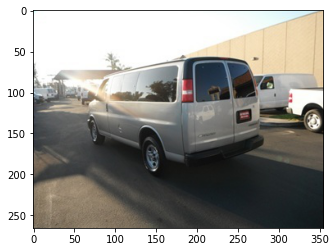

In [33]:
rand = str(randint(1, len(trainLabels)-5000)).zfill(5)
fname = rand + ".jpg"
print(fname)
f = '/tmp/train/cars_train/' + fname
im1_before = mpimg.imread(f)
imshow(im1_before)


2) Validation Image with zooming

In [34]:
#fname = trainLabels[5]
#fname
# output: [259, 289, 515, 416, 123, '00006.jpg']

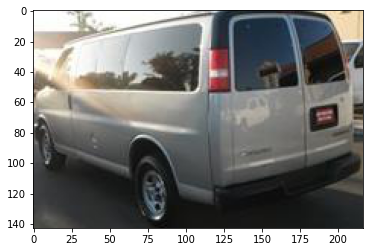

In [35]:
for i in trainLabels:
    if fname == i[5]:
        c_num = int(i[4])
        clAppend = str(Dictionary.get(c_num)) + '/'
        app = clAppend + fname
        path = '/tmp/processedTrain/' + app
        image1 = mpimg.imread(path)# image after
        imshow(image1)
        break
#imshow(image1)

Example of Original test image

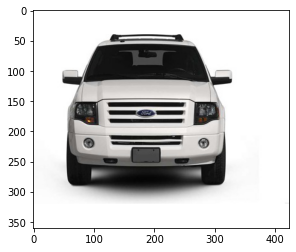

In [36]:
im1_before = mpimg.imread("/tmp/test/cars_test/00281.jpg")
imshow(im1_before)

Example of processed test image

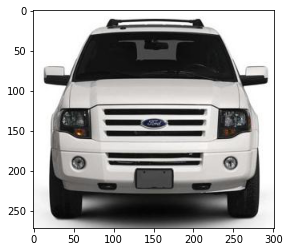

In [37]:
 im1_before = mpimg.imread("/tmp/boundedTest/00281.jpg")
imshow(im1_before)

**Transform and load**

Thanks to [Example 2, 7, 9](https://www.programcreek.com/python/example/105102/torchvision.datasets.ImageFolder)

In [38]:
# def get_train_loader(directory):
#     if hvd.rank() == 0:
#         print('Train: ', end="")
#     train_dataset = datasets.ImageFolder(directory,
#                                          transform=data_transform)

#     train_sampler = torch.utils.data.distributed.DistributedSampler(
#         train_dataset, num_replicas=hvd.size(), rank=hvd.rank())

#     train_loader = DataLoader(train_dataset, batch_size=batch_size,
#                               sampler=train_sampler, num_workers=4, pin_memory=True)

#     if hvd.rank() == 0:
#         print('Found', len(train_dataset), 'images belonging to',
#               len(train_dataset.classes), 'classes')
#     return train_loader, train_sampler



#     transforms.Compose(
#             [transforms.Resize(256),
#              transforms.RandomCrop(224),
#              transforms.RandomHorizontalFlip(),
#              transforms.ToTensor(),
#              transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225]) 

In [39]:
def getTrainLoad(directory):
    data = datasets.ImageFolder(directory, 
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

def getTestLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
trainLoad = getTrainLoad('/tmp/processedTrain')
validLoad = getTestLoad('/tmp/processedValidation')
testLoad = getTestLoad('/tmp/processedTest/')


**Transfer Learning**

**The Resnet34 for Image Classification we will use here**

**Creation of the model**

Many thanks to [transfer learning](https://discuss.pytorch.org/t/issues-with-transfer-learning/127288) and [Use Resnet34 for Image Classification](https://blog.roboflow.com/custom-resnet34-classification-model/)


In [41]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = 'cuda'
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Train the model**

In [42]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.to(device)
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    model.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

Epoch #  1,             Valid Loss: 5.62225,             Training Loss: 5.20749,             Valid Accuracy: 0.00625
Epoch #  2,             Valid Loss: 5.98699,             Training Loss: 0.73979,             Valid Accuracy: 0.01875
Epoch #  2,             Valid Loss: 6.74591,             Training Loss: 3.86667,             Valid Accuracy: 0.025
Epoch #  3,             Valid Loss: 7.47232,             Training Loss: 0.75387,             Valid Accuracy: 0.025
Epoch #  3,             Valid Loss: 8.22316,             Training Loss: 2.30276,             Valid Accuracy: 0.03051
Epoch #  4,             Valid Loss: 8.70025,             Training Loss: 0.59701,             Valid Accuracy: 0.01875
Epoch #  4,             Valid Loss: 9.14092,             Training Loss: 1.461,             Valid Accuracy: 0.02426
Epoch #  5,             Valid Loss: 9.29855,             Training Loss: 0.56792,             Valid Accuracy: 0.01875
Epoch #  5,             Valid Loss: 9.14636,             Training Loss

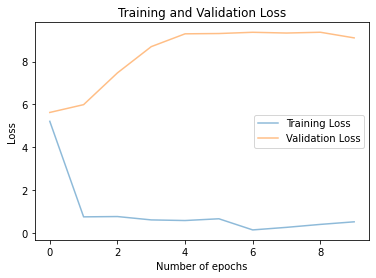

In [64]:
plt.plot(tr_loss_hist,label='Training Loss', alpha=0.5)
plt.title("Training and Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend()

plt.plot(v_loss_hist,label='Validation Loss', alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend()

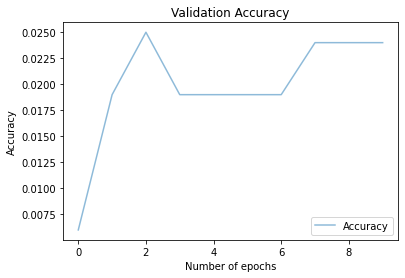

In [66]:
plt.plot(v_acc_hist,label='Accuracy', alpha=0.5)
plt.title("Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend()

**Test the model accuracy**

The process of running a trained model on new data is called evaluation or inference in deep learning. In order to do an evaluation, we need to put the network in eval mode: [Use of ‘model.eval()’ and ‘with torch.no_grad()’ in PyTorch model evaluate](https://androidkt.com/use-of-model-eval-and-with-torch-no_grad-in-pytorch-model-evaluate/)

In [68]:
model.to(device)

start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("We tested: ", len(testLabels)," images in the model")
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", end - start)


We tested:  8041  images in the model
Total accurate predictions: 6179
Accuracy of model w/ full test dataset fed: 76.84367616%
Testing time in seconds: 1121.7268414497375


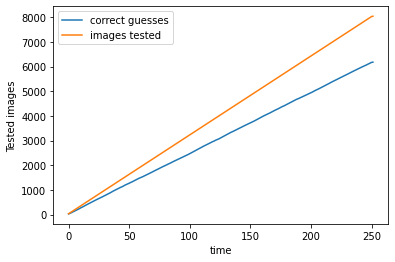

In [69]:
plt.plot(acc_hist, label='correct guesses')
plt.plot(tot_hist, label='images tested')
plt.xlabel('time')
plt.ylabel('Tested images')
plt.legend()
plt.show()

**deepcopy a model**

Make a CPU copy of the Model for testing

In [70]:
import copy
model_copy = copy.deepcopy(model)
model_copy.to('cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, idx = find_classes("/tmp/processedTest/")

Open the image

[Python torchvision.transforms.Resize() Examples](https://www.programcreek.com/python/example/104834/torchvision.transforms.Resize)

In [72]:
def predict(image, model, topk=5):
    pil_in = PIL.Image.open(image)
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    pilTrans = transform(pil_in)
    img = np.array(pilTrans)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor) #np to tensor
    dimen = img_tensor.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        output = model.forward(dimen)
    probs_top = output.topk(topk)[0]
    top_prediction = output.topk(topk)[1]
    p = np.array(top_prediction)[0]
    o_guesses = np.array(top_prediction)[0]
    return p, o_guesses

In [73]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, idx = find_classes("/tmp/processedTest/")

def predict(image, model, topk=5):
    #open image and change to np form//cpu consideration
    pil_in = PIL.Image.open(image)
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    pilTrans = transform(pil_in)
    img = np.array(pilTrans)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor) #np to tensor
    dimen = img_tensor.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        output = model.forward(dimen)
    probs_top = output.topk(topk)[0]
    top_prediction = output.topk(topk)[1]
    p = np.array(top_prediction)[0]
    o_guesses = np.array(top_prediction)[0]
    return p, o_guesses

**Randomly pick a test image to predict**

The randomly chosen file to classify is:  /tmp/boundedTest/05205.jpg
The seconds elapsed for prediction: 0.17507386207580566
*******************************
Image guessed as:  Ford F-150 Regular Cab 2007
*******************************
or: Ford F-150 Regular Cab 2012
or: Ford Ranger SuperCab 2011
or: Dodge Ram Pickup 3500 Quad Cab 2009
or: Ford Mustang Convertible 2007 



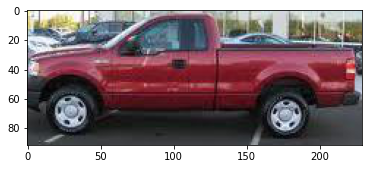

In [75]:
random_test_image = str(str(randint(1, len(testLabels))).zfill(5)) + '.jpg'
image_to_classify = "/tmp/boundedTest/" + random_test_image
device = ('cpu')
start = time.time()
tp, ps = predict(image_to_classify, model_copy, topk=5)
print("The randomly chosen file to classify is: ",image_to_classify)
end = time.time()
print("The seconds elapsed for prediction:", end - start)
print("*******************************")
print("Image guessed as: ",classes[ps[0]])
print("*******************************")
print("or:", classes[ps[1]])
print("or:", classes[ps[2]])
print("or:", classes[ps[3]])
print("or:", classes[ps[4]], "\n")
gimg = mpimg.imread(image_to_classify)
imshow(gimg)
